In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
from IPython.core.display import display, HTML
from bs4 import BeautifulSoup
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from tqdm import tqdm

from langdetect import detect
import gensim
from gensim.models import CoherenceModel
import gensim.models.doc2vec as d2v
from gensim import corpora
from gensim.summarization import summarize
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import wordnet, stopwords
from stop_words import get_stop_words
import pyLDAvis
import pyLDAvis.gensim as viz
from textblob import TextBlob
from wordcloud import WordCloud

from collections import Counter
import string
from nostril import nonsense
import json
from profanity_check import predict, predict_prob

pyLDAvis.enable_notebook()

In [2]:
%matplotlib inline
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['figure.dpi'] = 100
NUM = 3

In [3]:
# loc = 'placespeak.html'

# names_selector = 'ps-discussion-post-name'
# dates_selector = 'ps-discussion-post-time'
# comments_selector = 'ps-discussion-post-content'

# with open(loc, 'r', encoding='utf8') as f:
#     html = f.read()
# soup = BeautifulSoup(html, 'html.parser')

# names = tuple(n.string for n in soup.find_all('p', class_=names_selector))
# dates = tuple(d.string for d in soup.find_all('p', class_=dates_selector))
# comments = tuple(d.string for d in soup.find_all(
#     'p', class_=comments_selector))


import collections
from collections import defaultdict
def tree():
    return collections.defaultdict(tree)
groupedidea = tree()
df = pd.read_csv("text_analytics_v2_withoutLDA3.csv", usecols = ['comment','idea_id','task_id','user_id','emotion', 'polarity', 'subjectivity_score','sentiment_final','subjectivity','profanity','named_entities_corenlp', 'created_at'])
pd.to_datetime(df.created_at)
newdf = df.groupby('idea_id')

for row, col in newdf:
    print(row)
    groupedidea[row] = col

final_idea = dict(groupedidea)


1
2
3
4
6
10
14
15
22
23
24
25
26
27
31
32
33
34
35


In [4]:
# for i in range(32, 35):
#     print (i)
df = final_idea[34]

df = df.reset_index()
df

,index,comment,idea_id,task_id,user_id,created_at,emotion,polarity,subjectivity_score,subjectivity,profanity,sentiment_final,named_entities_corenlp
0,174,I really like this design.,34,14,74,8/27/2017 19:53,Happy,0.200000,0.200000,Fact,0.081731,positive,NaN
1,175,I would have to know the cost to create this p...,34,6,74,8/27/2017 19:54,Fear,0.200000,0.300000,Fact,0.076269,positive,NaN
2,176,I believe it will have a very possitive impact...,34,16,74,8/27/2017 20:03,Excited,0.300000,0.650000,Opinion,0.078629,positive,NaN
3,301,"Beautiful, but we already have an iconic pedes...",34,10,124,8/30/2017 22:01,Angry,0.583333,0.833333,Opinion,0.079142,negative,"LOCATION-Harbor Petco Park,"
4,302,Other than safety for pedestrians crossing the...,34,14,124,8/30/2017 22:03,Fear,-0.125000,0.375000,Fact,0.127102,negative,NaN


### Load into Pandas

In [5]:
# df = pd.read_csv("feedback.csv", usecols = ['comment','idea_id','task_id','user_id','created_at'])
# pd.to_datetime(df.created_at)

df = df[df['comment'].apply(lambda x: isinstance(x, str))]
# df['comment'] = df['comment'].astype(str)
df = df.replace(to_replace= r'\\N', value= '', regex=True)

print(len(df.index), 'comments in dataset')


5 comments in dataset


#### Sample comment

## Analyze
### Basic preprocessing
#### Find and remove duplicates

In [6]:
df.drop_duplicates(subset='comment', keep='first', inplace=True)
print(len(df.index), 'comments remaining in the dataset')

5 comments remaining in the dataset


#### Language detection
For this demo, let's keep only the English langage comments
In this case, I need to detect whether they are the real comment-.-

In [7]:
VOWELS = "aeiou"
PHONES = ['sh', 'ch', 'ph', 'sz', 'cz', 'sch', 'rz', 'dz']

def isWord(word):
    if word:
        consecutiveVowels = 0
        consecutiveConsonents = 0
        for idx, letter in enumerate(word.lower()):
            vowel = True if letter in VOWELS else False

            if idx:
                prev = word[idx-1]               
                prevVowel = True if prev in VOWELS else False
                if not vowel and letter == 'y' and not prevVowel:
                    vowel = True

                if prevVowel != vowel:
                    consecutiveVowels = 0
                    consecutiveConsonents = 0

            if vowel:
                consecutiveVowels += 1
            else:
                consecutiveConsonents +=1

            if consecutiveVowels >= 3 or consecutiveConsonents > 3:
                return False

            if consecutiveConsonents == 3:
                subStr = word[idx-2:idx+1]
                if any(phone in subStr for phone in PHONES):
                    consecutiveConsonents -= 1
                    continue    
                return False                

    return True

In [8]:
def third_party_detect_is_word(i):
    try:
        if nonsense(i):
           return False
        else:
           return True
    except ValueError:
        return False


    

# Detect Error as some errors occured in this dataset
# for df.index in df['comment']:
#     try:
#         language = detect(df['comment'])
#     except:
#         language = "error"
#         print("This row throws and error:", row[0])
#     row.append(language)
#     all.append(df['comment'])
    


df = df[df['comment'].apply(third_party_detect_is_word)]
print(len(df.index), 'comments remaining in dataset')
df

5 comments remaining in dataset


,index,comment,idea_id,task_id,user_id,created_at,emotion,polarity,subjectivity_score,subjectivity,profanity,sentiment_final,named_entities_corenlp
0,174,I really like this design.,34,14,74,8/27/2017 19:53,Happy,0.200000,0.200000,Fact,0.081731,positive,NaN
1,175,I would have to know the cost to create this p...,34,6,74,8/27/2017 19:54,Fear,0.200000,0.300000,Fact,0.076269,positive,NaN
2,176,I believe it will have a very possitive impact...,34,16,74,8/27/2017 20:03,Excited,0.300000,0.650000,Opinion,0.078629,positive,NaN
3,301,"Beautiful, but we already have an iconic pedes...",34,10,124,8/30/2017 22:01,Angry,0.583333,0.833333,Opinion,0.079142,negative,"LOCATION-Harbor Petco Park,"
4,302,Other than safety for pedestrians crossing the...,34,14,124,8/30/2017 22:03,Fear,-0.125000,0.375000,Fact,0.127102,negative,NaN


### Quantitative analysis

#### Common word counts

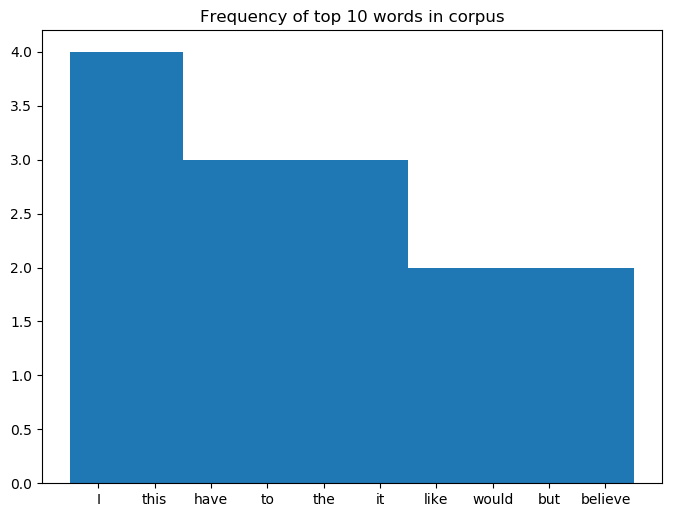

In [9]:
full_text = ' '.join(text for text in df['comment']).split()


def plot_top_10_words(texts: list):
    """Plots the top 10 words in a strings list"""
    labels, values = zip(*Counter(texts).most_common(10))

    indexes = np.arange(len(labels))
    width = 1

    plt.bar(indexes, values, width)
    plt.xticks(indexes, labels)
    plt.title('Frequency of top 10 words in corpus')
    plt.show()


plot_top_10_words(full_text)

#### Word Cloud

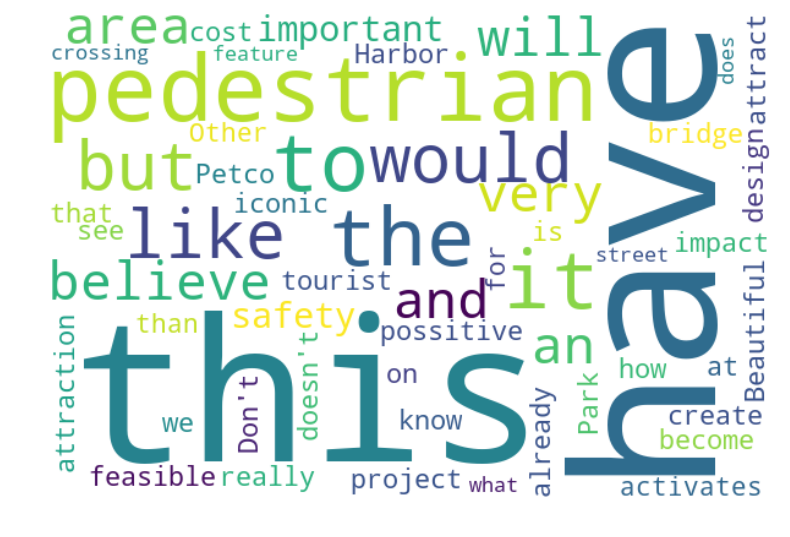

In [10]:
# Generate a word cloud image
def plot_word_cloud(text: str, stopwords=None, title='', filename=None):
    """Given string full of whitespace-delimited words, plots a word cloud"""
    wordcloud = WordCloud(width=600,
                          height=400,
                          background_color="white",
                          stopwords=stopwords,).generate(text)
    fig, ax = plt.subplots()
    ax.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout()
    plt.title(title)
    if filename:
        plt.savefig(filename)


plot_word_cloud(text=' '.join(full_text), stopwords=[])

Well that's not so informative! We'll need some text preprocessing before we get anywhere and cut through linguistic noise. For now, hold on to that thought, we'll get back to it later.

### Preprocess

In [11]:
custom_stop_words = ['the', 'for', 'can', 'this', 'i.e.', 'm', 's', 'e',
                    't', 'use', 'what', 'it', 'will', 'just']

In [12]:
def all_digits(n):
    """Returns True if string n contains all digits"""
    return all(i in string.digits for i in n)


def preprocess_docs(documents):
    # Set up word handling
    tokenizer = RegexpTokenizer(r'\w+')
    en_stop = get_stop_words('en') + custom_stop_words
    assert 'and' in en_stop
    p_stemmer = PorterStemmer()

    # Perform the clustering
    texts = []
    for doc in documents:
        raw = doc.lower()
        tokens = tokenizer.tokenize(raw)

        # Remove stop words and numbers from tokens
        stopped_tokens = [
            i for i in tokens if i not in en_stop and not all_digits(i)]
        assert 'this' not in stopped_tokens
        
        texts.append(stopped_tokens)
    return texts


comments = preprocess_docs(df['comment'].values)
print(len(comments), 'comments pre-processed')

5 comments pre-processed


### Bigrams
For words like "New York", we need to have them as separate entities, and not just "New" and "York". These are called bigrams, and we'll add them to the corpus. Trigrams are 3 words frequently occurring.

Some examples in our example are: ‘front_bumper’, ‘oil_leak’, ‘maryland_college_park’ etc.

Gensim’s Phrases model can build and implement the bigrams, trigrams, quadgrams and more. The two important arguments to Phrases are min_count and threshold. The higher the values of these param, the harder it is for words to be combined to bigrams.

In [13]:
# Build the bigram and trigram models
# higher threshold fewer phrases.
bigram = gensim.models.Phrases(comments, min_count=4)

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)

comments = [bigram_mod[comment] for comment in comments]
processed_text = sum(comments, [])

In [14]:
# Link it back to original DataFrame
df['processed'] = [' '.join(comment) for comment in comments]
df.sample(2)

,index,comment,idea_id,task_id,user_id,created_at,emotion,polarity,subjectivity_score,subjectivity,profanity,sentiment_final,named_entities_corenlp,processed
2,176,I believe it will have a very possitive impact...,34,16,74,8/27/2017 20:03,Excited,0.3,0.65,Opinion,0.078629,positive,NaN,believe possitive impact area become important...
1,175,I would have to know the cost to create this p...,34,6,74,8/27/2017 19:54,Fear,0.2,0.30,Fact,0.076269,positive,NaN,know cost create project like believe feasible


Now! Let's look at the word distribution

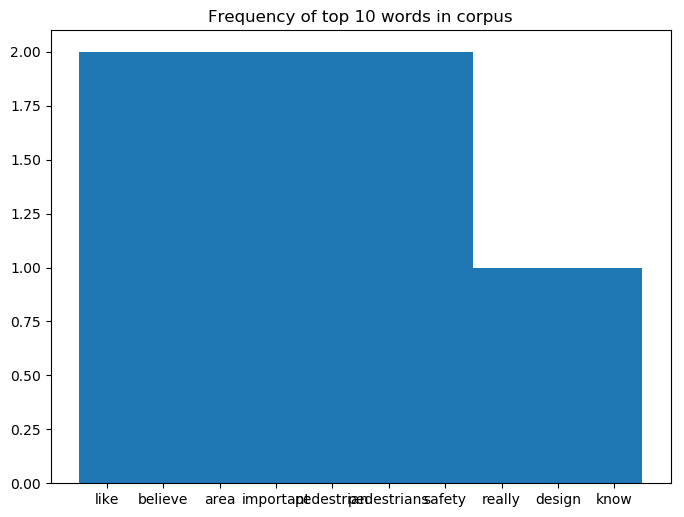

In [15]:
plot_top_10_words(processed_text)

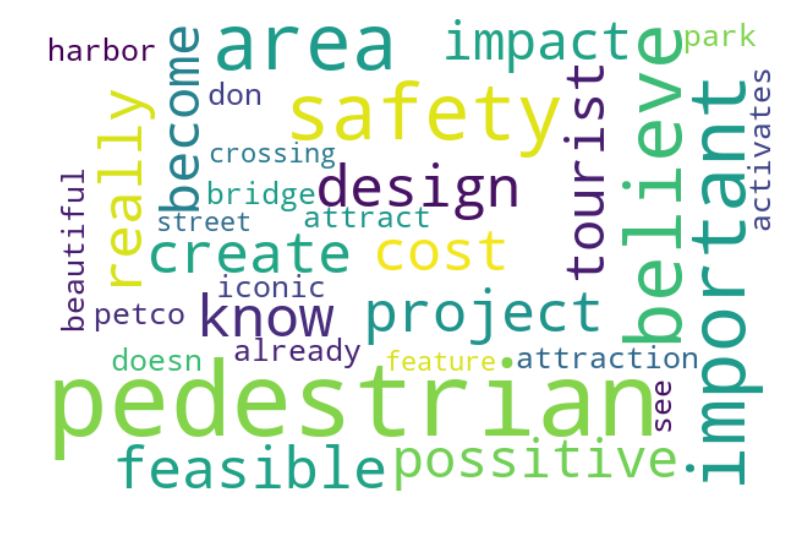

In [16]:
plot_word_cloud(' '.join(processed_text))

## Latent Dirichlet Allocation (LDA) Topic Model
### Train

In [17]:
dictionary = corpora.Dictionary(comments)
corpus = [dictionary.doc2bow(comment) for comment in comments]

In [18]:
models = []
for num in tqdm(range(2, 10)):
    ldamodel = gensim.models.LdaMulticore(corpus, id2word=dictionary, num_topics=num)
    coherence = CoherenceModel(model=ldamodel, corpus=corpus, dictionary=dictionary, coherence='u_mass')
    models.append((num, ldamodel, coherence.get_coherence()))

100%|██████████| 8/8 [00:01<00:00,  5.96it/s]


In [19]:
df_models = pd.DataFrame(models)
df_models.head(30)

,0,1,2
0,2,"LdaModel(num_terms=34, num_topics=2, decay=0.5...",-13.662436
1,3,"LdaModel(num_terms=34, num_topics=3, decay=0.5...",-14.241976
2,4,"LdaModel(num_terms=34, num_topics=4, decay=0.5...",-14.176095
3,5,"LdaModel(num_terms=34, num_topics=5, decay=0.5...",-16.877080
4,6,"LdaModel(num_terms=34, num_topics=6, decay=0.5...",-16.978000
5,7,"LdaModel(num_terms=34, num_topics=7, decay=0.5...",-17.351141
6,8,"LdaModel(num_terms=34, num_topics=8, decay=0.5...",-17.413213
7,9,"LdaModel(num_terms=34, num_topics=9, decay=0.5...",-17.467386


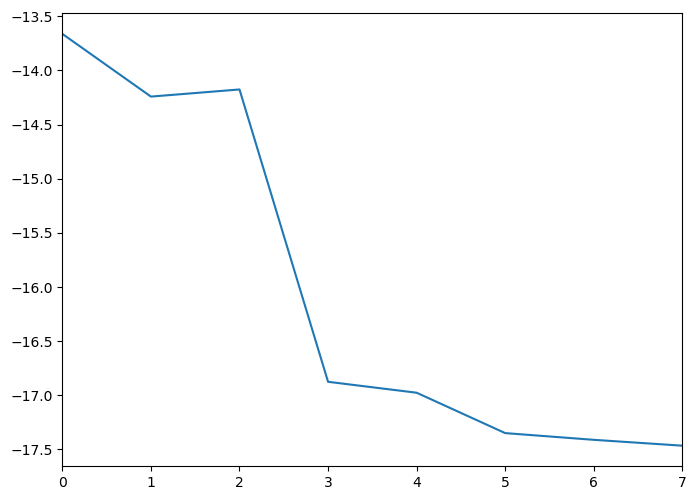

In [20]:
df_models[2].plot()

In this case, let's go with `n=9` as the optimal number of topics. We already know that comments usually mention multiple topics in the same go, so this small number still can intuitively make sense.

In [21]:
ldamodel = df_models[df_models[0] == 2][1].values[0]

### Visualize the model

In [ ]:
visualization = viz.prepare(ldamodel, corpus, dictionary)
filename_viz = 'outputs/ldaviz35.html'
pyLDAvis.save_html(visualization, filename_viz)

# visualization

### Top topic per comment

In [22]:
import os
import re
import serialize
from numpy import *
from operator import itemgetter

def redundant(topPhrases, tar_words, threshold=0.66):
    """ returns 1 if the new phrase is redundant """

    flag = 0        
    for ph in topPhrases:
        src_words = set(re.split(" ", ph))
        overlap   = len(src_words.intersection(tar_words)) / float( len(tar_words) )
        
        if overlap > threshold:
            flag = 1
            break
            
    return flag

def extract_phrases(wrd_score, tagged):
    
    """ mark the top keywords in text and extract key phrases """

    phrases_score = {}
    [phrase, pos, score]   = ["", "", 0]
        
    for id, element in enumerate(tagged):
        if (element[0] in wrd_score):
            phrase += element[0] + " "
            pos    += element[1] + " "            
            score  = wrd_score.get(element[0], 0) if wrd_score.get(element[0], 0) > score else score
        elif phrase and re.search("NN", pos):
            phrases_score[phrase.strip()] = score 
            [phrase, pos, score]   = ["", "", 0]

    return phrases_score  

def computePageRank(adj_matrix, dum_factor= 0.85, tol= 0.00001):
    """ Compute Pagerank """

    #prepare adj matrix by normalizing
    T = array(adj_matrix, dtype=float32) 
    row_sums = T.sum(axis=1)

    if any(row_sums <= 0):
        print ("error in row_sums. a value is <= 0!")
        raw_input(' ')

    A = T / row_sums[:, newaxis]      
    (r1, c1) = A.shape
    A =  ( (1- dum_factor) / r1 )  + ( dum_factor * A )

    if any(A <= 0):
        print ("error in A.. a value is <= 0!")
        raw_input(' ')
         
    #apply power method to compute the eigen vector
    eigVec = ones((r1, 1)) / r1        

    while 1:
        eigVec_a = dot(A.T, eigVec)
        delta    = linalg.norm(eigVec_a - eigVec)
            
        if delta < tol:
            break
            
        eigVec = eigVec_a 
    
    return eigVec  

def unique_everseen(iterable):
    "List unique elements, preserving order. Remember all elements ever seen."
    # unique_everseen('AAAABBBCCDAABBB') --> A B C D unique_everseen('ABBCcAD', str.lower) --> A B C D

    seen = set()
    for element in iterable:
        k = str.lower(element)
        if k not in seen:
            seen.add(k)
            yield element

def readStopWordList(stopfile):
    """ read the stop word list """
    
    #print "Reading the stop word list......"    
    stopWords = {}
    FILEr = open(stopfile, 'r')
    
    for line in FILEr:
        line = line.strip()
        stopWords[line.lower()] = stopWords.get(line.lower(), 0) + 1
    
    FILEr.close()
#     serialize.saveData("stop_word", stopWords)
    return stopWords
    
def filter_for_tags(tagged, stopWords):
    """ find adj and nouns """
    return [(item[0].replace('.', ''), item[1]) for item in tagged if re.search("(JJ|NN)", item[1])  and  re.search("[\w\d]+", item[0]) and not (item[0].lower() in stopWords) ]


def findTopicLabels(topic_sent):
    """ find topic labels """ 
    
    #load stop words
    stopWords = readStopWordList("stopWordSpeech") # stop word file from Galley-03; run it only for the first time
#     stopWords = serialize.loadData("stop_word")

    #read the utterances
    frame_len = 10 #nb of sentences 
    #print rawDataDir
    #for infile1 in sorted (glob (os.path.join (rawDataDir, "*.txt"))):
#        print "Generating labels for " + infile1

        #FILEr1  = open(infile1, 'r')
        #full_text = FILEr1.read()
        #FILEr1.close()
    all_sentences=topic_sent
    #all_sentences = re.split("\s*\n+\s*", full_text)

    for index in range(0, len(all_sentences), frame_len):

        text =  "\n". join(all_sentences[index:index+frame_len])
        #print text

        tagged_bef = nltk.pos_tag(nltk.word_tokenize(text))
        tagged = filter_for_tags(tagged_bef, stopWords) #apply syntactic filter           

        unique_word_set = list (unique_everseen([x[0] for x in tagged]))
        adjMat = [ [0 for m in range(len(unique_word_set))] for n in range(len(unique_word_set)) ]

        for i, word1 in enumerate(unique_word_set):
            word1 = unique_word_set[i]
            adjMat[i][i] += 1

            for j in range(i+1, len(unique_word_set)):
                word2 = unique_word_set[j]
                window_word1 = " ".join([word1, word2])
                window_word2 = " ".join([word2, word1])
                try:
                    adjMat[i][j] += len (re.findall(window_word1, text))
                except:
                    print (window_word1)
                    continue                    
                try:
                    adjMat[j][i] += len (re.findall(window_word2, text))
                except:
                    print (window_word2)
                    continue

        pr_score = computePageRank(adjMat, dum_factor= 0.85, tol= 0.00001)

        #associate words with the scores
        wrd_score  = dict(zip(unique_word_set, pr_score.ravel().tolist()))
        #get phrases
        phrases_score    = extract_phrases(wrd_score, tagged_bef)

        #apply MMR and produce final list of K keyphrases
        [topPhrases, top_ph_sc, isFirst]  = [[], [], 1]
        ratio = 0.5
        K = int (len(phrases_score.keys()) * ratio)

        for (ph, sc) in sorted(phrases_score.items(), key=itemgetter(1), reverse=True):

            if isFirst:
                topPhrases.append(ph)
                top_ph_sc.append(sc)
                isFirst = 0
                continue

            words = re.split(" ", ph)

            if not redundant(topPhrases, set(words), threshold=0.75) and len(topPhrases) < K:
                topPhrases.append(ph)
                top_ph_sc.append(sc)

            if len(topPhrases) == K:
                    break

        phstr  = ", ". join( [ ph + "_" + "(" + str(sc) + ")" for ph, sc in zip(topPhrases, top_ph_sc) ] )
        print (K)
        #print phstr
        return phstr
        #raw_input(' ')

<>:100: DeprecationWarning: invalid escape sequence \w
<>:100: DeprecationWarning: invalid escape sequence \w
<>:100: DeprecationWarning: invalid escape sequence \w
<ipython-input-22-fee73889f51f>:100: DeprecationWarning: invalid escape sequence \w
  return [(item[0].replace('.', ''), item[1]) for item in tagged if re.search("(JJ|NN)", item[1])  and  re.search("[\w\d]+", item[0]) and not (item[0].lower() in stopWords) ]


In [23]:
# TODO: Join to main df instead of creating a new one
def format_topics_sentences(ldamodel=ldamodel, corpus=corpus, texts=df['comment']):
    
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series(
                    [int(topic_num), round(prop_topic, 4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic',
                              'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    sent_topics_df = pd.concat([sent_topics_df, texts], axis=1)
    return sent_topics_df


df_topic_sents_keywords = format_topics_sentences()

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = [
#     'Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text' , 'findTopicLabels']
    'Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text' ]


# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.8449,"pedestrian, like, important, area, believe, pe...",I really like this design.
1,1,1.0,0.9259,"pedestrian, like, important, area, believe, pe...",I would have to know the cost to create this p...
2,2,0.0,0.7931,"safety, pedestrians, feature, street, crossing...",I believe it will have a very possitive impact...
3,3,1.0,0.9676,"pedestrian, like, important, area, believe, pe...","Beautiful, but we already have an iconic pedes..."
4,4,0.0,0.9240,"safety, pedestrians, feature, street, crossing...",Other than safety for pedestrians crossing the...


### Augmenting the dataset with most salient topic per comment

In [24]:
# nltk.download('punkt')
df_final = pd.merge(df, df_dominant_topic, left_on=df.index, right_on='Document_No')
for col in ['Document_No',  'Text']:
    try:
        del df_final[col]
    except:
        pass


for i, n in df_final.groupby('Dominant_Topic'):
    df_final.at[n.index, 'findTopicLabels'] = findTopicLabels(n["comment"])
    
df_final.sample(5)


3
4


,index,comment,idea_id,task_id,user_id,created_at,emotion,polarity,subjectivity_score,subjectivity,profanity,sentiment_final,named_entities_corenlp,processed,Dominant_Topic,Topic_Perc_Contrib,Keywords,findTopicLabels
4,302,Other than safety for pedestrians crossing the...,34,14,124,8/30/2017 22:03,Fear,-0.125000,0.375000,Fact,0.127102,negative,NaN,safety pedestrians crossing street safety feature,0.0,0.9240,"safety, pedestrians, feature, street, crossing...",important tourist attraction_(0.22853713946296...
1,175,I would have to know the cost to create this p...,34,6,74,8/27/2017 19:54,Fear,0.200000,0.300000,Fact,0.076269,positive,NaN,know cost create project like believe feasible,1.0,0.9259,"pedestrian, like, important, area, believe, pe...",iconic pedestrian bridge_(0.14140545774204466)...
0,174,I really like this design.,34,14,74,8/27/2017 19:53,Happy,0.200000,0.200000,Fact,0.081731,positive,NaN,really like design,1.0,0.8449,"pedestrian, like, important, area, believe, pe...",iconic pedestrian bridge_(0.14140545774204466)...
2,176,I believe it will have a very possitive impact...,34,16,74,8/27/2017 20:03,Excited,0.300000,0.650000,Opinion,0.078629,positive,NaN,believe possitive impact area become important...,0.0,0.7931,"safety, pedestrians, feature, street, crossing...",important tourist attraction_(0.22853713946296...
3,301,"Beautiful, but we already have an iconic pedes...",34,10,124,8/30/2017 22:01,Angry,0.583333,0.833333,Opinion,0.079142,negative,"LOCATION-Harbor Petco Park,",beautiful already iconic pedestrian bridge doe...,1.0,0.9676,"pedestrian, like, important, area, believe, pe...",iconic pedestrian bridge_(0.14140545774204466)...


In [25]:
# We get a few comments that can't be assigned to any topic
len(df_final[df_final['Dominant_Topic'].isnull()])

0

In [26]:
print(df_final[df_final['Dominant_Topic'].isnull()]['comment'].sample().values[0])

ValueError: a must be greater than 0

That one is odd, seems like it should definitely sit with topic #5 or #7. Oh well!

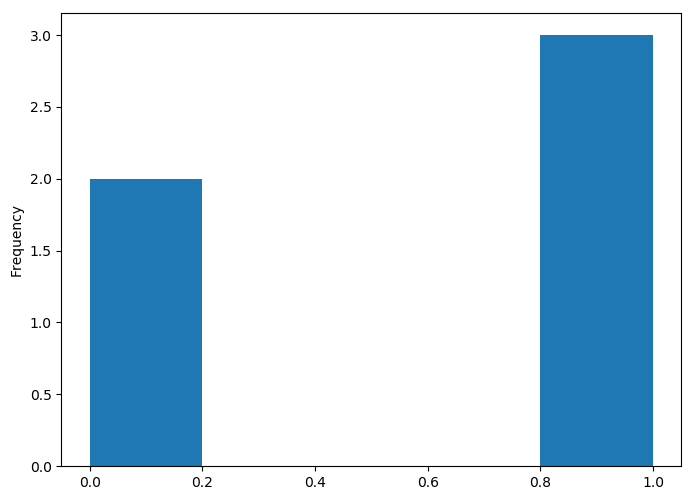

In [27]:
df_final['Dominant_Topic'].plot.hist(bins=5)

## Save to CSV

In [ ]:
df_final